Basic Walkthrough:
     1) Define everything
     2) Create master bias file, Save master bias file  
     3) Open all other files, sub master bias, save  (*c?.b.fits)
     4) Remove cosmics from all file types except bias  (*c?.bc.fits)
     5) Open flats and create master skyflat file, save
     6) Open all remainging types and divide out master flat, then save  (*c?.bcf.fits)
     7) Open all remaining types and stitch together, save  (*full.bcf.fits)
     8) Use fibermap files to determine aperatures
     9) Use aperatures to cut out same regions in thar,comp,science
     10) Save all 256 to files with their header tagged name in filename, along with fiber num
     11) Assume no curvature within tiny aperature region; fit profile to 2d spec and sum to 1d
     12) Fit the lines in comp spectra, save file and fit solution
     13) Try to fit lines in thar spectra, save file and fit solution
     14) Apply to science spectra

In [32]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.ndimage.filters import median_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from quickreduce_funcs import get_all_filedata

### Define input file numbers and other required information

Ex:

    Bias 597-626
    ThAr 627,635
    NeHgArXe 628,629,636,637
    Science 631-634
    Fibermaps 573-577


In [33]:
biass = np.arange(597,626+1).astype(int)
thar_lamps = np.asarray([627,635])
comp_lamps = np.asarray([628,629,636,637])
twiflats = np.arange(582,591+1).astype(int)
sciences = np.arange(631,634+1).astype(int)
fibermaps = np.arange(573,577+1).astype(int)

In [34]:
instrument = 'M2FS'
mask_name = 'A02'
cal_lamp = ['HgAr', 'NeAr', 'Ar', 'Xe']  # 'Xenon','Argon','Neon', 'HgNe'
thar_cal_lamp = ['ThAr']
cameras = ['r']
opamps = [1,2,3,4]

In [35]:
path_to_masks = os.path.abspath('../../OneDrive/Research/M2FSReductions')
mask_subdir = mask_name
raw_data_subdir =  'raw_data'
filename_template['raw'] = '{cam}{filenum:04d}c{opamp}.fits'

In [36]:
make_debug_plots = False
print_headers = True
cut_bias_cols = True
convert_adu_to_e = True
load_data_from_disk_each_step = False

In [37]:
do_step = OrderedDict()
do_step['stitch'] = False
do_step['bias'] = False
do_step['remove_crs']   = False
do_step['ffmerge'] = False
do_step['apcut'] = True
do_step['wavecalib'] = True
do_step['flat'] = False
do_step['combine'] = True
do_step['zfit'] = True

###         Beginning of Code

In [38]:
date = np.datetime_as_string(np.datetime64('today', 'D'))

In [39]:
directory['mask'] = os.path.join(path_to_masks,mask_subdir)

In [40]:
directory['raw_data'] =     os.path.join(directory['mask'], raw_data_subdirectory)
directory['raw_stitched'] = os.path.join(directory['mask'],'raw_stitched')
directory['product'] =      os.path.join(directory['mask'],'data_products')
directory['twod'] =         os.path.join(directory['mask'],'twods')
directory['oned'] =         os.path.join(directory['mask'],'oneds')
directory['calibrated'] =   os.path.join(directory['mask'],'calibrated_oned')
directory['summedspec'] =   os.path.join(directory['mask'],'final_oned')
directory['zfit'] =         os.path.join(directory['mask'],'zfits')
directory['linelists'] = os.path.join(os.curdir,'lamp_linelists','salt')

for dirpath in directory.values():
    if not os.path.exists(dirpath):
        os.makedirectorys(dirpath)

In [43]:
filenumbers = {'bias':biass, 'thar':thar_lamps, 'comp': comp_lamps,
               'twiflat':twiflats, 'science': sciences, 'fibmap': fibermaps}

In [44]:
filename_template['base'] =      '{cam}_{imtype}_{filenum:04d}_{maskname}_'
filename_template['stitched'] =  filename_template['base']+'stitched{tags}.fits'
filename_template['twod'] =      filename_template['base']+'{fibername}_2d{tags}.fits'
filename_template['oned'] =      filename_template['base']+'{fibername}_1d{tags}.fits'
filename_template['combined'] =  filename_template['base']+'{fibername}_combined_1d{tags}.fits'
filename_template['linelist'] =  '{lamp}.txt'

filename_template['master_stitched'] =  '{cam}_master{imtype}_{maskname}_stitched{tags}.fits'

In [45]:
common_info =      {    'maskname':         mask_name,
                        'cameras':          cameras,
                        'opamps':           opamps, 
                        'date':             date,
                        'datadir':          directory['raw_data'],
                        'savetodir'         directory['raw_stitched'],
                        'curtemplate':      filename_template['raw'],
                        'savetotemplate':   filename_template['stitched'],
                        'master_template':  filename_template['master_stitched'],
                        'master_types':     [],
                        'savetags':         '',
                        'curtags':          ''      }

In [ ]:
start = 'stitch'
for key,val in do_step.items():
    if val:
        start = key
        break

### How the hdudict is structured

    data, headers  
         keys: science, comp, thar, flat, fibmap
         vals: cameras_dict
              
         cameras_dict 
                keys: r, b
                vals: filenumbers_dict
                           
                filenumbers_dict 
                        keys: integer numbers
                        vals: opampdict
                                            
                        opampdict 
                               keys: ints 1, 2, 3, 4
                               vals: hdus for each of 4 opamps

In [ ]:
if load_data_from_disk_each_step or ('stitch' == start):
    ## Load in data
    data, headers = get_all_filedata( filenum_dict=filenumbers, **common_info,
                                      cut_bias_cols=cut_bias_cols, 
                                      convert_adu_to_e = convert_adu_to_e )

In [ ]:
if do_step['stitch']:
    from quickreduce_funcs import stitch_these_camera_data
    for imtype in filenumbers.keys():
        data_dict = data[imtype]
        header_dict = headers[imtype]
        stitched_data[imtype] = {}
        stitched_headers[imtype] = {}
        for camera in data_dict.keys():
            stchd_dat,stchd_headers = stitch_these_camera_data(data_dict,header_dict,filenumbers,camera,imtype,
                                                               common_info,save_each=True)
            stitched_data[imtype][camera] = stchd_dat
            stitched_headers[imtype][camera] = stchd_headers
            
    if do_step['bias']:       
        imtype = 'bias'
        data_dict = data[imtype]
        header_dict = headers[imtype]

        stitched_data[imtype] = {}
        stitched_headers[imtype] = {}

        for camera in data_dict.keys():
            stchd_dat,stchd_headers = stitch_these_camera_data(data_dict,header_dict,filenumbers,camera,imtype,
                                                               common_info,save_each=False)
            filenum_3d_array = np.asarray(list(stchd_dat.values()))
            filenum_median_array = np.median(filenum_3d_array,axis=0)

            header = list(stchd_headers.values())[0]
            header.add_history("Median Master Bias done by quickreduce on {}".format(date))

            outhdu = fits.PrimaryHDU(data=filenum_median_array ,header=header)
            outname = common_info['master_template'].format(cam=camera, imtype=imtype,maskname=mask_name, 
                                                           tags=common_info['savetags'])
            filename = os.path.join(common_info['savetodir'], outname)
            outhdu.writeto( filename ,overwrite=True)

            ## Plot the image
            plt.figure()
            plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
            plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
            plt.savefig(filename.replace('.fits','.png'),dpi=1200)
            plt.show()

            stitched_headers[imtype][camera] = header
            stitched_data[imtype][camera] = filenum_median_array
        
    data, headers = stitched_data,stitched_headers

In [49]:
## Now that stitching is complete. opamps = None
filenumbers.pop('bias')
common_info['master_types'].append('bias')
common_info['opamps'] = None
common_info['datadir'] = directory['stitched']
common_info['savetodir'] = directory['product']
common_info['curtags'] = ''
common_info['savetags'] = '.b'    

In [50]:
if load_data_from_disk_each_step or ('bias' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

In [52]:
if do_step['bias']:
    imtype = 'bias'
    master_bias_data = data[imtype]
    master_bias_headers = headers[imtype]
    debiased_data = {}
    debiased_headers = {}
    for camera,master_bias in master_bias_data.items():
        for imtype,filenums in filenumbers.items():
            debiased_data[imtype] = {camera: {}}
            debiased_headers[imtype] = {camera: {}}
            for filenum in filenums:
                filnumarray = stitched_data[imtype][camera][filenum].astype(float)
                header = stitched_headers[imtype][camera][filenum]
                filnumarray -= master_bias.astype(float)
                header.add_history("Bias Subtracted done by quickreduce on {}".format(date))
                outhdu = fits.PrimaryHDU(data=filnumarray ,header=header)  
                outname = common_info['curtemplate'].format(cam=camera,imtype=imtype, maskname=mask_name,
                                                            filenum=filenum,tags=common_info['savetags'])

                filename = os.path.join(common_info['datadir'], outname)
                outhdu.writeto( filename ,overwrite=True)

                ## Plot the image
                plt.figure()
                plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
                plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.show()

                debiased_data[imtype][camera][filenum] = header
                debiased_headers[imtype][camera][filenum] = filnumarray
            print("Completed bias subtraction for {}".format(imtype))
            print("Results saved to {}".format(common_info['datadir']))
    
    data, headers = debiased_data, debiased_headers

In [ ]:
common_info['curtags'] = '.b'
common_info['savetags'] = '.bc' 
common_info['datadir'] = directory['product']
common_info['savetodir'] = directory['product']

if load_data_from_disk_each_step or ('remove_crs' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

In [53]:
if do_step['remove_crs']:
    import PyCosmic 
    for imtype in filenumbers.keys():
        for camera in common_info['cameras']:
            for filenum in filenumbers[imtype]:
                filename = common_info['curtemplate'].format(cam=camera, imtype=imtype, maskname=mask_name,
                                                             filenum=filenum, tags=common_info['curtags'])
                filename = os.path.join(common_info['datadir'],filename)
                savefile = filename.replace(common_info['curtags']+'.fits',common_info['savetags']+'.fits')
                maskfile = filename.replace(common_info['curtags']+'.fits',common_info['curtags']+'.crmask.fits')
                print("\nFor image type: {}, shoe: {},   filenum: {}".format(imtype,camera,filenum))
                outdat,pycosmask,pyheader = PyCosmic.detCos(filename,maskfile,savefile,rdnoise='ENOISE',sigma_det=8,
                                                            gain='EGAIN',verbose=True,return_data=True)
                ## Plot the image
                plt.figure()
                pycosmask = pycosmask - np.min(pycosmask) + 1e-4
                plt.imshow(np.log(pycosmask),'gray',origin='lowerleft')
                plt.savefig(maskfile.replace('.fits','.png'),dpi=1200)
                plt.close()
                ## Plot the image
                plt.figure()
                pycos = outdat - np.min(outdat) + 1e-4
                plt.imshow(np.log(pycos),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.close()

In [54]:
common_info['curtags'] = '.bc'
common_info['savetags'] = '.bc'  
common_info['datadir'] = directory['product']
common_info['savetodir'] = directory['product']

if load_data_from_disk_each_step or ('apcut' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

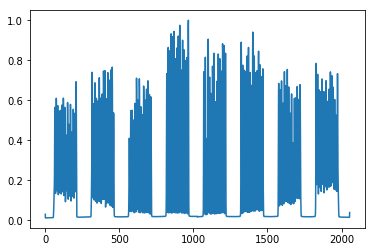

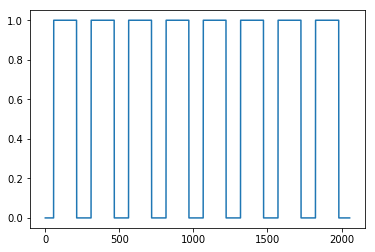

<Figure size 432x288 with 0 Axes>

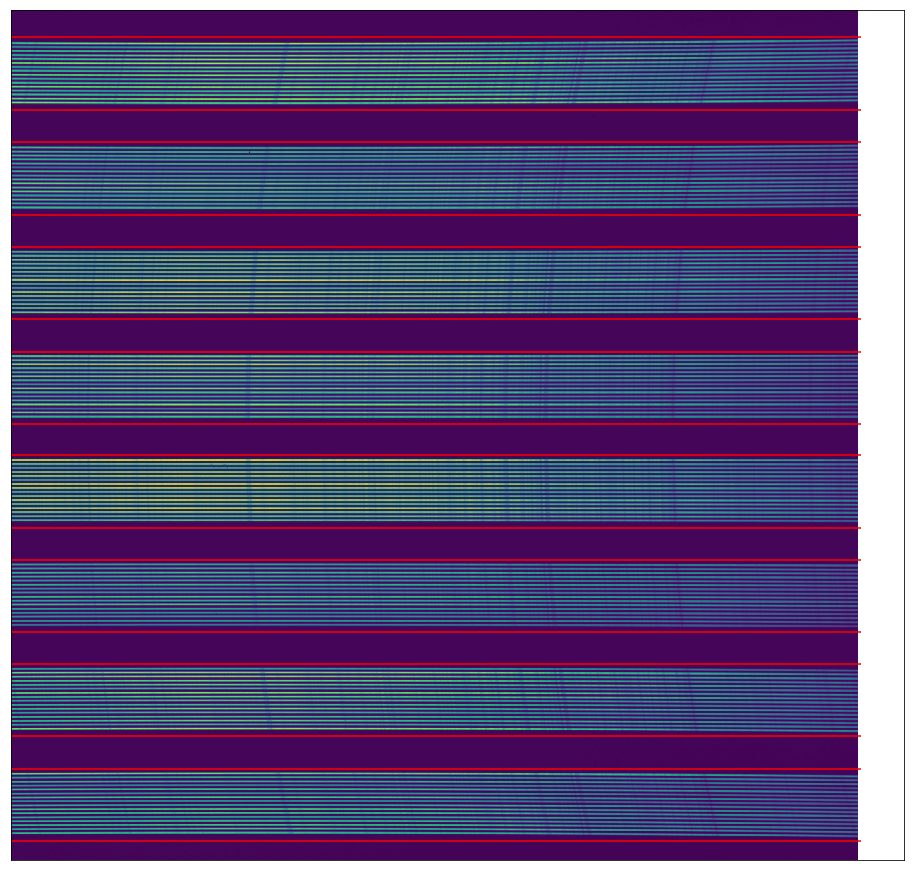

In [57]:
if do_step['apcut']:
    from app_detection_helper_funcs import find_aperatures,cutout_1d_aperatures
    relevant_info = {}
    relevant_info['camera'] = common_info['cameras'][0]
    relevant_info['deadfibers'] = None
    relevant_info['resol_factor'] = 100
    relevant_info['nvertslices'] = 2**6
    relevant_info['function_order'] = 4

    aperatures = find_aperatures(cr_removed_data['fibmap'][common_info['cameras'][0]],**relevant_info)

In [58]:
if do_step['apcut']:
    from app_detection_helper_funcs import cutout_1d_aperatures
    apcut_data = {}
    for imtype in cr_removed_data.keys():
        apcut_data[imtype] = {}
        for camera in [common_info['cameras'][0]]:
            data = cr_removed_data[imtype][camera]
            if type(data) is dict:
                apcut_data[imtype][camera] = {}
                for filenum in filenumbers[imtype]:
                    image = data[filenum]
                    oneds = cutout_1d_aperatures(image,aperatures)
                    apcut_data[imtype][camera][filenum] = oneds
            else:
                image = data
                oneds = cutout_1d_aperatures(image,aperatures)
                apcut_data[imtype][camera] = oneds

dict_keys([628, 629, 636, 637])


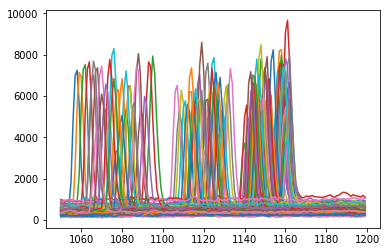

In [59]:
if do_step['apcut']:
    plt.figure()
    print(apcut_data['comp']['r'].keys())
    for dat in apcut_data['science']['r'][633].values():
        plt.plot(range(len(dat)),dat)


In [60]:
import pickle as pkl
if do_step['apcut']:
    with open('pkldump.pkl','wb') as pdump:
        pkl.dump(apcut_data,pdump)

In [61]:
apcut_data = None
if not do_step['apcut']:
    with open('pkldump.pkl','rb') as pdump:
        apcut_data = pkl.load(pdump)

In [50]:
common_info['curtags'] = '.bc'
common_info['savetags'] = '.bc'  
common_info['datadir'] = directory['product']
common_info['savetodir'] = directory['product']

if load_data_from_disk_each_step or ('wavecalib' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

In [62]:
deltat = np.datetime64('now','m').astype(int)-np.datetime64('2018-06-01T00:00','m').astype(int)
filename = os.path.join(path_to_calibs,'calib_wave_coefs_{}_{}.dat'.format(camera, deltat))

NameError: name 'path_to_calibs' is not defined

In [ ]:
from wavelength_calibration_funcs import calibrate_pixels2wavelengths

In [63]:
cr_removed_headers['thar']['r'].keys()

dict_keys([627, 635])

In [55]:
common_info['master_types'].append('twiflat')
common_info['master_types'].append('fibmap')
filenumbers.pop('twiflat')
filenumbers.pop('fibmap')
common_info['curtags'] = '.bc'
common_info['savetags'] = '.bcf'
common_info['datadir'] = directory['product']
common_info['savetodir'] = directory['product']

if load_data_from_disk_each_step or ('flat' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

array([573, 574, 575, 576, 577])

In [ ]:
if do_step['flat']:
    for imtype in ['twiflat','fibmap']:
        for camera in cr_removed_data[imtype].keys():
            filenum_3d_array = np.asarray(list(data[imtype][camera].values()))
            header =list(headers[imtype][camera].values())[0]
            
            for exposure in range(filenum_3d_array.shape[0]):
                ## get exposure and make sure there are no negative values
                current_exposure = filenum_3d_array[exposure,:,:]
                current_exposure -= np.min(current_exposure)
                ## get a median smoothed version to remove any peculiarities, find it's max
                median_exposure = median_filter(current_exposure,size=5)
                ## divide by the max of the median exposure to normalize (excluding outliers)
                current_exposure /= np.max(median_exposure)
                filenum_3d_array[exposure,:,:] = current_exposure
            
            filenum_summed_array = np.median(filenum_3d_array,axis=0)
            header.add_history("Summed Master {} done by quickreduce on {}".format(imtype,date))

            outhdu = fits.PrimaryHDU(data=filenum_summed_array ,header=header)
            outname = filename_template['master_stitched'].format(cam=camera, imtype=imtype,maskname=mask_name, 
                                                           tags=common_info['tags'])
            filename = os.path.join(common_info['datadir'], outname)
            outhdu.writeto( filename ,overwrite=True)

            ## Plot the image
            plt.figure()
            plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
            plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
            plt.savefig(filename.replace('.fits','.png'),dpi=1200)
            plt.show()

            headers[imtype][camera] = header
            data[imtype][camera] = filenum_summed_array
            
    master_twiflat_data = data['twiflat']
    flat_data, flat_headers = {}, {}
    for imtype in filenumbers.keys():
        flat_data[imtype] = {}
        flat_headers[imtype] = {}
        for camera,master_twiflat in master_twiflat_data.items():
            master_twiflat /= np.max(master_twiflat)
            flat_data[imtype][camera] = {}
            flat_headers[imtype][camera] = {}
            datadict = data[imtype][camera]
            
            headerdict = headers[imtype][camera]
            for filnum,filearray in datadict.items():
                filearray = filearray.astype(float)
                header = headerdict[filnum]
                filearray /= master_twiflat.astype(float)
                header.add_history("Flat correction done by quickreduce on {}".format(date))
                outhdu = fits.PrimaryHDU(data=filearray ,header=header)
                filename = common_info['curtemplate'].format(cam=camera, imtype=imtype, 
                                                             maskname=mask_name, 
                                                             filenum=filnum, \
                                                             tags=common_info['savetags'])
                filename = os.path.join(common_info['datadir'], filename)
                outhdu.writeto( filename ,overwrite=True)

                ## Plot the image
                plt.figure()
                plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
                plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.show() 
                
                flatnd_data[imtype][camera][filnum] = header
                flatnd_headers[imtype][camera][filnum] = filearray

    print("Completed flattening for {}".format(imtype))
    print("Results saved to {}".format(common_info['datadir']))
    del cr_removed_data, cr_removed_headers

In [ ]:
if load_data_from_disk_each_step or ('combine' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)

In [ ]:
if load_data_from_disk_each_step or ('zfit' == start):
        data, headers = get_all_filedata(filenum_dict=filenumbers, **common_info)